<a href="https://colab.research.google.com/github/UMB200/pytorch_projects/blob/main/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1.0 Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.1 Get data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### 1.2 Prepare data

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8e52de7d40>,
 ['pizza', 'steak', 'sushi'])

### 1.3 Get and prepare a pretrained model

In [ ]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### 1.4 Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
res_0 = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 11.832 seconds


### 1.5 Make predictions on the entire test dataset with the model

In [ ]:
# Making predictions on the entire test dataset using the model 0
model_0.eval()
test_prediction_list = []
with torch.inference_mode():
  for X_test, y_test in test_dataloader:
    X_test, y_test = X_test.to(device), y_test.to(device)
    logits = model_0(X_test)
    pred_probs = torch.softmax(logits, dim=1)
    prediction_output = torch.argmax(pred_probs, dim=1)
    test_prediction_list.append(prediction_output)

test_prediction_list = torch.cat(test_prediction_list).cpu()
test_prediction_list

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### 1.6 Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


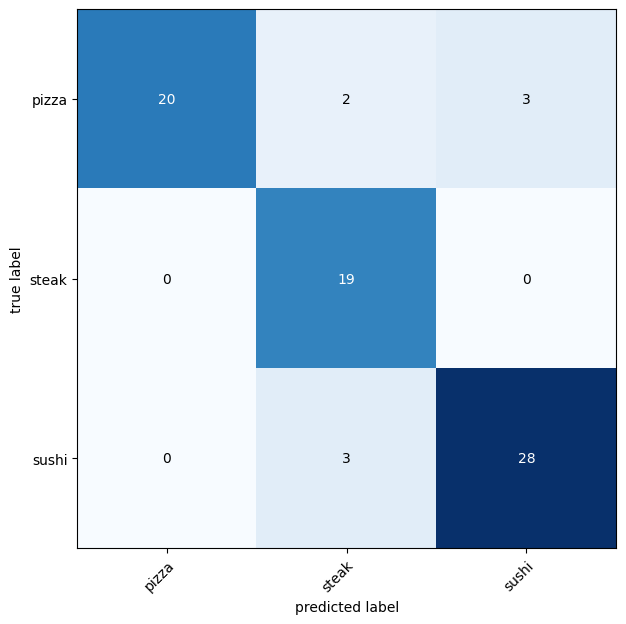

In [ ]:
# Make confusion matrix with the test preds and the truth labels
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
import numpy as np

truth_labels = torch.cat([y_test for X_test, y_test in test_dataloader])
# 2.Setup confusion matrix instance and compare prediction to targets
cm = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
cm_tensor  = cm(preds=test_prediction_list, target=truth_labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cm_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7));

## 2.0 Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [ ]:
# TODO V1
# Convert both predictions and to lists
from collections import Counter
pred_probs = test_prediction_list.cpu().tolist()
truth_list = truth_labels.cpu().tolist()

# find mismatch
mismatched_preds = [(actual, pred) for actual, pred in zip(truth_list, pred_probs) if actual != pred]

# count mismatched
mismatched_count = Counter(mismatched_preds)

# get top 5 most common mismatches
top_5_mismatches = mismatched_count.most_common(5)

# print out top 5 mismatched predictions
top_5_mismatches_list = [(class_names[actual], class_names[pred], count) for (actual, pred), count in top_5_mismatches]

print(f"Top 5 Most Mismatched Predictions")
for actual, pred, count in top_5_mismatches_list:
    print(f"Actual: {actual} | Pred: {pred} | Count: {count}")

Top 5 Most Mismatched Predictions
Actual: pizza | Pred: sushi | Count: 3
Actual: sushi | Pred: steak | Count: 3
Actual: pizza | Pred: steak | Count: 2


In [ ]:
#TODO V2
# get test data paths
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
from PIL import Image

test_data_paths = list(test_dir.glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# get list of dicts with sample, label and predictions, pred probs
def get_pred_probs(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    pred_dicts = {}

    # sample path
    pred_dicts["image_path"] = path

    # get class name
    class_name = path.parent.stem
    pred_dicts["class_name"] = class_name

    # Get pred an pred prob
    img = Image.open(path)
    transform_img = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      logits = model(transform_img.to(device))
      pred_probs = torch.softmax(logits, dim=1)
      pred_lbl = torch.argmax(pred_probs, dim=1)
      pred_class = class_names[pred_lbl.cpu()]

      # put dicts in cpu
      pred_dicts["pred_probs"] = pred_probs.unsqueeze(0).max().cpu().item()
      pred_dicts["class_names"] = pred_class

    pred_dicts["correct"] = pred_class == class_name

    test_pred_list.append(pred_dicts)

  return test_pred_list

test_pred_dicts = get_pred_probs(
    test_paths = test_data_paths,
    model = model_0,
    transform= simple_transform,
    class_names = class_names,
    device = device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.4503762423992157,
  'class_names': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.4661272168159485,
  'class_names': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.4742574989795685,
  'class_names': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.5894519090652466,
  'class_names': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.5992532968521118,
  'class_names': 'pizza',
  'correct': True}]

In [ ]:
# Plot top 5 mismatches
import pandas as pd
import matplotlib.pyplot as plt
test_pred_df = pd.DataFrame(test_pred_dicts)
top_5_wrongs = test_pred_df.sort_values(by=["correct", "pred_probs"], ascending=[True, False]).head()
top_5_wrongs

,image_path,class_name,pred_probs,class_names,correct
46,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.546966,steak,False
52,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.449595,steak,False
20,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.444701,sushi,False
11,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.435138,sushi,False
19,data/pizza_steak_sushi/test/pizza/309892.jpg,pizza,0.426874,sushi,False


/tmp/ipython-input-3490515232.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
/tmp/ipython-input-3490515232.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
/tmp/ipython-input-3490515232.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_probs = row[2]
/tmp/ipython-input-3490515232.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

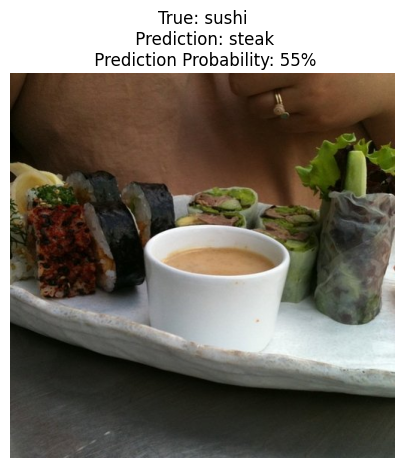

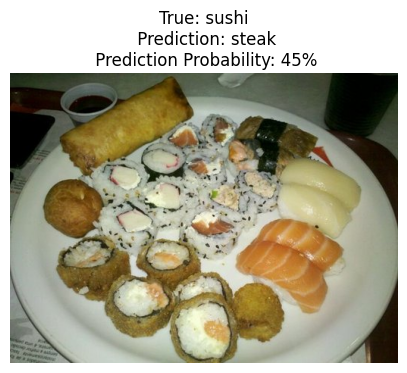

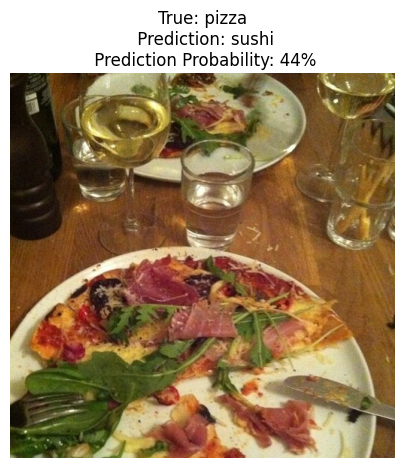

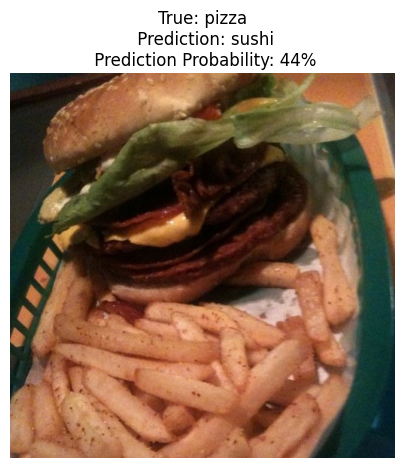

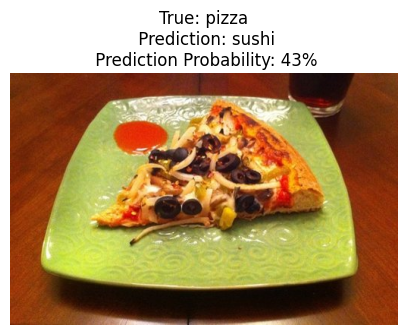

In [ ]:
for row in top_5_wrongs.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_probs = row[2]
  pred_class = row[3]
  img = torchvision.io.read_image(str(image_path))
  plt.figure(figsize=(5, 5))
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"True: {true_label}\n Prediction: {pred_class}\n Prediction Probability: {pred_probs:.0%}")
  plt.axis(False)


## 3.0 Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [ ]:
# Create a function to predict on target image
from PIL import Image
from typing import List, Tuple
from torchvision import transforms
import matplotlib.pyplot as plt

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform: transforms = None,
                        device: torch.device = device):
  target_img = Image.open(image_path)

  if transform is not None:
    img_transform = transform
  else:
    img_transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_img_transform = img_transform(target_img).unsqueeze(dim=0)
    target_img_pred = model(target_img_transform.to(device))
  target_img_pred_probs = torch.softmax(target_img_pred, dim=1)
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)
  plt.figure()
  plt.imshow(target_img)
  plt.title(f"Prediction: {class_names[target_img_pred_label.cpu()]} | Prob: {target_img_pred_probs.max().cpu():.0%}")
  plt.axis(False)

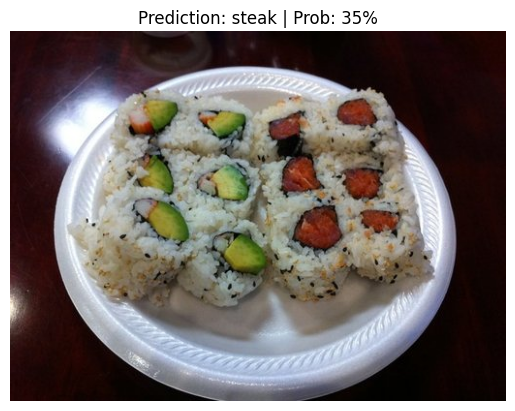

In [ ]:
# TODO: Get an image of pizza/steak/sushi
custom_image_path = Path("data/pizza_steak_sushi/test/sushi/175783.jpg")
img = torchvision.io.read_image(str(custom_image_path))

pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    device=device)

In [ ]:
# get an image if non-pizza
import requests
!wget https://plus.unsplash.com/premium_photo-1754408286846-b18dfacd7eff
!cp premium_photo-1754408286846-b18dfacd7eff not_pizza.jpg

with Image.open("not_pizza.jpg") as f:
  (width, height) = (f.width // 10, f.height //10)
  f_resized = f.resize((width, height))
  #f_resized.save("not_pizza_resized.jpg")

f_resized
not_food_custom_image_path = Path("not_pizza.jpg")

--2025-08-21 16:16:34--  https://plus.unsplash.com/premium_photo-1754408286846-b18dfacd7eff
Resolving plus.unsplash.com (plus.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to plus.unsplash.com (plus.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3362578 (3.2M) [image/jpeg]
Saving to: ‘premium_photo-1754408286846-b18dfacd7eff’

premium_photo-17544 100%[===================>]   3.21M  --.-KB/s    in 0.06s   

2025-08-21 16:16:34 (57.9 MB/s) - ‘premium_photo-1754408286846-b18dfacd7eff’ saved [3362578/3362578]



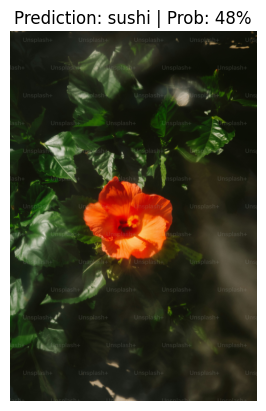

In [ ]:
# Predict on an image of not pizza/steak/sushi
pred_and_plot_image(model=model_0,
                    image_path=not_food_custom_image_path,
                    class_names=class_names,
                    device=device)

## 4.0 Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# TODO: Recreate a new model

from going_modular.going_modular import data_setup, engine
from timeit import default_timer as timer

model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

for param in model_1.features.parameters():
    param.requires_grad = False

output_shape = len(class_names)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# TODO: Train the model for 10 epochs
start_time = timer()
res_1 = engine.train(model=model_1,
                   train_dataloader=train_dataloader,
                   test_dataloader=test_dataloader,
                   optimizer=optimizer_1,
                   loss_fn=loss_fn_1,
                   epochs=10,
                   device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1297 | train_acc: 0.3008 | test_loss: 1.0613 | test_acc: 0.4924
Epoch: 2 | train_loss: 1.1277 | train_acc: 0.3945 | test_loss: 1.0823 | test_acc: 0.3807
Epoch: 3 | train_loss: 1.1016 | train_acc: 0.3320 | test_loss: 1.1009 | test_acc: 0.2888
Epoch: 4 | train_loss: 1.1337 | train_acc: 0.2656 | test_loss: 1.1134 | test_acc: 0.2992
Epoch: 5 | train_loss: 1.1148 | train_acc: 0.3281 | test_loss: 1.1220 | test_acc: 0.2898
Epoch: 6 | train_loss: 1.1347 | train_acc: 0.3047 | test_loss: 1.1254 | test_acc: 0.2576
Epoch: 7 | train_loss: 1.1166 | train_acc: 0.3242 | test_loss: 1.1197 | test_acc: 0.2576
Epoch: 8 | train_loss: 1.1091 | train_acc: 0.3789 | test_loss: 1.1310 | test_acc: 0.2689
Epoch: 9 | train_loss: 1.1091 | train_acc: 0.4492 | test_loss: 1.1282 | test_acc: 0.2585
Epoch: 10 | train_loss: 1.1141 | train_acc: 0.4297 | test_loss: 1.1244 | test_acc: 0.2689
[INFO] Total training time: 16.678 seconds


## 5.0 Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### 5.1 Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
f_name = "pizza_steak_sushi_20_percent"
f_type = ".zip"
image_path = data_path / f_name
image_data_zip_path = (f_name + f_type)

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/" + f_name + f_type)
        print(f"Downloading {f_name}")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print(f"Unzipping  {f_name} 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### 5.2 Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8e525b0ef0>,
 ['pizza', 'steak', 'sushi'])

### 5.3 Get a pretrained model

In [ ]:
# TODO
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

for param in model_2.features.parameters():
    param.requires_grad = False

output_shape = len(class_names)

model_2.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 5.4 Train a model with 20% of the data

In [ ]:
from going_modular.going_modular import engine
from timeit import default_timer as timer

loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

start_time = timer()
res_2 = engine.train(model=model_2,
                   train_dataloader=train_dataloader_20_percent,
                   test_dataloader=test_dataloader_20_percent,
                   optimizer=optimizer_2,
                   loss_fn=loss_fn_2,
                   epochs=5,
                   device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9754 | train_acc: 0.5687 | test_loss: 0.6801 | test_acc: 0.8386
Epoch: 2 | train_loss: 0.7119 | train_acc: 0.8083 | test_loss: 0.5449 | test_acc: 0.8881
Epoch: 3 | train_loss: 0.5650 | train_acc: 0.8354 | test_loss: 0.4667 | test_acc: 0.9097
Epoch: 4 | train_loss: 0.4823 | train_acc: 0.8708 | test_loss: 0.4145 | test_acc: 0.9284
Epoch: 5 | train_loss: 0.4548 | train_acc: 0.8729 | test_loss: 0.3955 | test_acc: 0.9193
[INFO] Total training time: 16.373 seconds


## 6.0 Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# TODO
weight_eff_net_b2 = torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1
transform_eff_net_b2 = weight_eff_net_b2.transforms()

In [ ]:
train_dataloader_eff_net_b2, test_dataloader_eff_net_b2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,                                                    test_dir=test_dir,
    transform=transform_eff_net_b2,
    batch_size=32)

In [ ]:
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

for param in model_3.features.parameters():
  param.requires_grad = False

output_shape = len(class_names)

model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
    out_features=output_shape,
    bias=True)).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 178MB/s]


In [ ]:
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()
res_3 = engine.train(model=model_3,
                     train_dataloader=train_dataloader_eff_net_b2,
                   test_dataloader=test_dataloader_eff_net_b2,
                   optimizer=optimizer_3,
                   loss_fn=loss_fn_3,
                     epochs=5,
                   device=device)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.4023 | test_loss: 0.9384 | test_acc: 0.6525
Epoch: 2 | train_loss: 0.8715 | train_acc: 0.8008 | test_loss: 0.8467 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.7597 | train_acc: 0.8359 | test_loss: 0.7965 | test_acc: 0.7955
Epoch: 4 | train_loss: 0.7335 | train_acc: 0.7539 | test_loss: 0.6938 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.6452 | train_acc: 0.8086 | test_loss: 0.6697 | test_acc: 0.8778
[INFO] Total training time: 14.368 seconds


In [ ]:
# Check effnet_b0 results with 10% of data for 5 epochs
#max(res_0["test_acc"]), min(res_0["test_loss"])
# Check effnet_b0 results with 10% of data for 10 epochs (double training time)
#max(res_1["test_acc"]), min(res_1["test_loss"])
# Check effnet_b0 results with 20% of data for 5 epochs (double data)
#max(res_2["test_acc"]), min(res_2["test_loss"])
# Check effnet_b2 results with 10% of data for 5 epochs (double model parameters)
#max(res_3["test_acc"]), min(res_3["test_loss"])

import pandas as pd
results_dict = {
    "model_0": {"test_acc": max(res_0["test_acc"]), "test_loss": min(res_0["test_loss"])},
    "model_1": {"test_acc": max(res_1["test_acc"]), "test_loss": min(res_1["test_loss"])},
    "model_2": {"test_acc": max(res_2["test_acc"]), "test_loss": min(res_2["test_loss"])},
    "model_3": {"test_acc": max(res_3["test_acc"]), "test_loss": min(res_3["test_loss"])}
}
results_df = pd.DataFrame(results_dict).T
display(results_df)


,test_acc,test_loss
model_0,0.896780,0.624355
model_1,0.492424,1.061291
model_2,0.928409,0.395503
model_3,0.887311,0.669686
